In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 10})
import cvxpy as cp

import sys
sys.path.append('D:/Work/dev/insitu_sim_python/insitu')
import lcurve_functions as lc

sys.path.append("..")
import regu_test_problems as tp

# A necessidade da regularização. 

Após a análise cuidadosa que efetuamos nas aulas anteriores, temos agora uma boa compreensão das dificuldades associadas aos problemas discretos mal postos e porque é que a **solução "ingénua"** pode ser **inútil**. Nesta aula, usamos este conhecimento para conceber vários métodos diferentes para calcular **soluções aproximadas** que que são **menos sensíveis a perturbações** do que a solução ingénua.

Estes métodos são chamados **métodos de regularização** porque impõem regularidade na solução calculada - normalmente sob a forma de um requisito de que a **solução é suave**, nalgum sentido. E ao impor esta regularidade, ou suavidade, suprimimos alguns dos componentes de ruído indesejados (a.k.a. componentes de alta frequência associados aos menores valores singulares), levando a soluções aproximadas mais estáveis. Quase todos os métodos de regularização tratados aqui produzem soluções que podem ser expressas como uma expansão SVD. 

# Relembremos

A expansão de uma matriz $\textbf{A} \in \mathbb{R}^{M \times L}$ ($M\geq L$) em **SVD** é uma poderosa ferramenta, especialmente porque se aplica também a **matrizes retangulares**. 

\begin{equation}
\textbf{A} = \textbf{U} \Sigma \textbf{V}^H=\sum\limits_{i=1}^{L}\textbf{u}_i \sigma_i \textbf{v}_{i}^{H}
\end{equation}
em que 

\begin{equation}
\Sigma = \text{diag}(\sigma_1, \sigma_2, ..., \sigma_L), \ \ \ \ \ \ \ \sigma_1 \geq \sigma_2 \geq \cdots \sigma_L
\end{equation}

As matrizes $\textbf{U} \in \mathbb{R}^{M \times L}$ e $\textbf{V} \in \mathbb{R}^{L \times L}$ são compostas por vetores colunas chamados de: 

- left singular vectors: $\textbf{U} = [\textbf{u}_1, \textbf{u}_2, \cdots, \textbf{u}_M]$
- right singular vectors: $\textbf{V} = [\textbf{v}_1, \textbf{v}_2, \cdots, \textbf{v}_L]$

e ambas as matrizes tem colunas ortonormais: $\textbf{u}_{i}^{H}\textbf{u}_{j} = \textbf{v}_{i}^{H}\textbf{v}_{j} = \delta_{ij}$, ou $\textbf{U}^{H}\textbf{U} = \textbf{V}^{H}\textbf{V} = \textbf{I}$.

O número de condição da matriz $\textbf{A}$ é

\begin{equation}
\text{cond}(\textbf{A}) = \sigma_1/\sigma_{L}
\end{equation}


A matriz pseudo-inversa, $\textbf{A}^{\dagger}$ existe, então

\begin{equation}
\textbf{A}^{\dagger} = \textbf{V} \Sigma^{-1} \textbf{U}^H = \sum\limits_{i=1}^{L}\frac{\textbf{u}_{i}^{H}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}
com $\Sigma^{-1} = \text{diag}(\sigma_{1}^{-1}, \sigma_{2}^{-1}, \cdots, \sigma_{L}^{-1})$.

# Os principais problemas

A amplitude do fenômeno medido é menor (**e mais sujeita à ruído)** para:
- maiores distâncias da fonte (decaimento natural do fenômeno)
- maiores frequências espaciais no fenômeno de origem (lema de Riemann–Lebesgue)
- As componentes de frequência espacial mais altas estão associadas aos menores valores singulares e, portanto, facilmente corrompidas por ruído.

# Vamos revisitar o problema base da aula passada

O problema inverso básico é baseado na **integral de Fredholm** de primeiro tipo, dada por

\begin{equation}
g(s) = \int_{0}^{1}K(s,t) f(t) \text{d}t
\end{equation}

Neste caso $f(t)$ é a **causa** (o que gostaríamos de inferir), $g(s)$ é o que medimos (**consequência**) e a função $K(s,t)$ é chamado de Kernel, e representa nosso **modelo**. Note que esta equação se parece com uma convolução, se $K(s,t)=h(s-t)$. Assim, o problema inverso pode ser visto como um tipo de **de-convolução**.

Vamos investigar um problema modelo e gerar alguns dados para investigar aspectos teóricos sobre a computação do problema inverso. O problema que queremos investigar é o problema de medir a densidade ao longo do espaço $\rho(x)$, que origina um campo gravitacional medido $g(x')$. Vamos re-escrever a equação acima pra deixá-la mais parecida com nossa notação.

\begin{equation}
g(x') = \int_{0}^{1}K(x',x) \rho(x) \text{d}x
\end{equation}

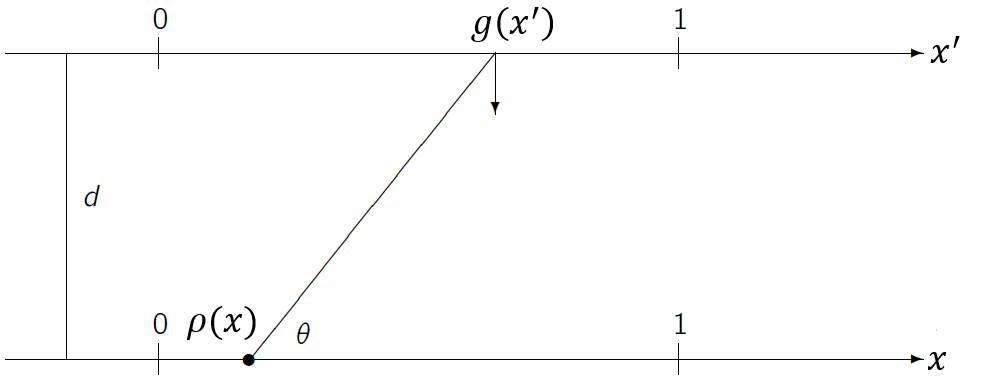

O campo gravitacional de uma parte infinitesimalmente pequena de $\rho(x)$, de comprimento $\text{d}x$, no eixo $x$ é $\rho(x) \text{d}x / r^2$, em que $r = \sqrt{d^2 + (x' - x)^2}$ é a distância entre o "**ponto fonte**" em $x$ e o "**ponto medido em campo**" em $x'$. A direção do campo gravitacional é no sentido: do "ponto medido em campo" para o "ponto fonte" e, portanto, o valor medido de $\text{d}g(x')$ é

\begin{equation}
\text{d}g(x') = \frac{\text{sin}(\theta)}{r^2}\rho(x) \text{d}x
\end{equation}
com $\text{sin}(\theta) = d/r$. O valor total de $g(x')$ consiste na integral da equação anterior, a saber

\begin{equation}
g(x') = \int_{0}^{1}\frac{d}{(d^2+(x' - x)^2)^{3/2}} \rho(x) \text{d}x
\end{equation}
com 

\begin{equation}
K(x',x) = \frac{d}{(d^2+(x' - x)^2)^{3/2}}
\end{equation}

Note que o **kernel** $K(x',x)$ será usado para computar nossa matriz $\textbf{A}$; a dimensão física da densidade é $\rho(x)$ [kg/m] (1D); falta a constante de gravitação universal, $G$ [Nm$^2$/kg$^2$]. O problema servirá para nos ensinar muitos aspectos. 

Vamos importar (do repositório) funções pra computar a matriz $\textbf{A}$ e o campo de densidades, expresso num vetor $\textbf{x}$, que é a causa do que será de fato medido no vetor $\textbf{b}$. 

In [14]:
# ordem
order = 64
# intervalo de medição
a = 0
b = 1
# distancia medida
d = 0.25
A, x = tp.gravity_model(n = order,a = a,b = b,d = d)
[U,s,V] = lc.csvd(A)

rhox = tp.density_sin(x, 0.5) + 0.5* tp.density_sin(x, 1.0)
gxl = A @ rhox

n = np.random.normal(loc = 0.0, scale = 0.05, size = len(gxl))
gxln = gxl + n

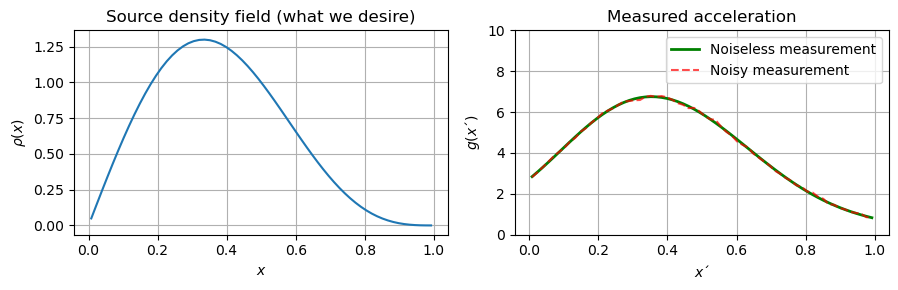

In [20]:
# Figure
fig, axs = plt.subplots(1, 2, figsize = (9,3))
axs[0].plot(x, rhox)
axs[0].grid(True)
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$\rho(x)$')
axs[0].set_title(r'Source density field (what we desire)')
axs[1].plot(x, gxl, '-g', linewidth = 2, label = r'Noiseless measurement')
axs[1].plot(x, gxln, '--r', label = r'Noisy measurement', alpha = 0.7)
axs[1].set_ylim((0, 10))
axs[1].legend(loc = 'upper right')
axs[1].grid(True)
axs[1].set_xlabel(r'$x´$')
axs[1].set_ylabel(r'$g(x´)$')
axs[1].set_title(r'Measured acceleration')
plt.tight_layout()

# A condição discreta de Picard
> Seja $\tau$ o nível a partir do qual os valores singulares computados $\sigma_i$ se nivelam devido a erros de arredondamento. A condição de Picard discreta é satisfeita se, para todos os valores $\sigma_i>\tau$, os coeficientes correspondentes $|\textbf{u}_{i}^{T}b|$, em média, decaem mais rapidamente do que os $\sigma_i$.

A solução inversa (ingênua) é expressa por

\begin{equation}
\textbf{x} = \textbf{A}^{\dagger}\textbf{b} = (\textbf{V} \Sigma^{-1} \textbf{U}^H)\textbf{b}=\sum\limits_{i=1}^{L}\frac{\textbf{u}_{i}^{H}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}

### A condição sem ruído

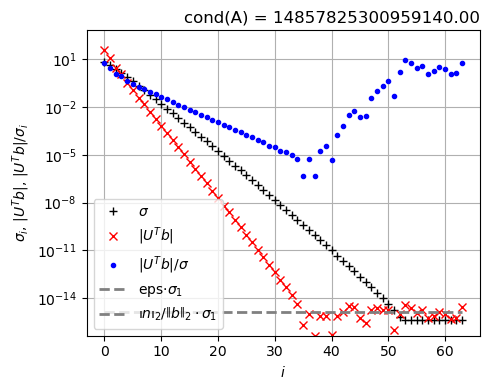

In [22]:
lc.plot_picard(U, s, gxl, noise_norm = 0)

### A condição com ruído

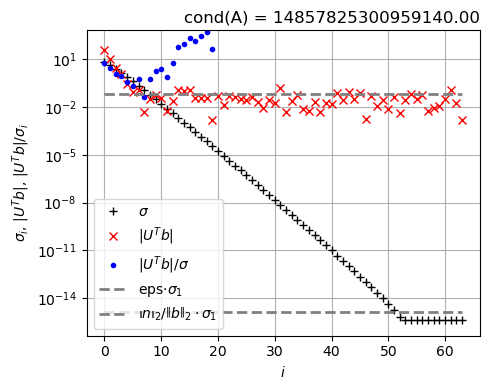

In [23]:
lc.plot_picard(U, s, gxln, noise_norm = np.linalg.norm(n))

# SVD e regularização

Uma vez que computamos o SVD da matriz $\textbf{A}$ e entendemos o papel da **condição discreta de Picard**, podemos re-expressar a solução da seguinte forma

\begin{equation}
\hat{\textbf{x}} = \sum\limits_{i=1}^{L}\varphi_i\frac{\textbf{u}_{i}^{H}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}
em que $\varphi_i$ são fatores de filtragem associados ao tipo de regularização aplicada.

Estes métodos de regularização podem ser designados por métodos de **filtragem espectral** porque, como vimos na aula passada, a base SVD pode ser considerada como uma base espectral.

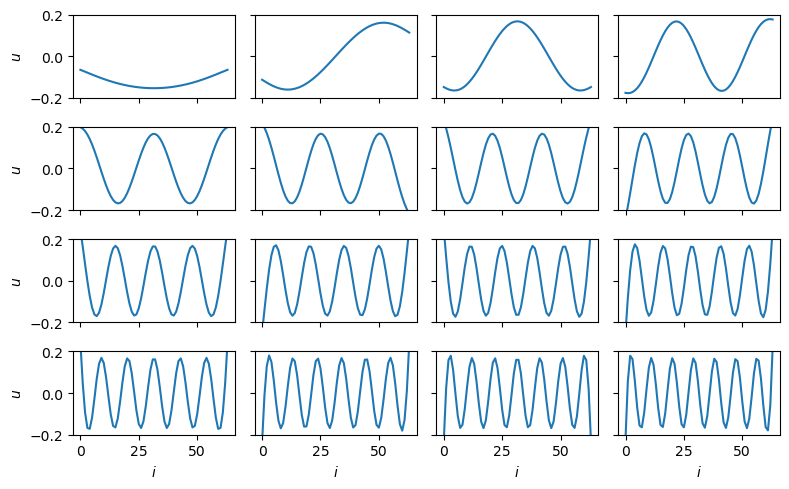

In [24]:
lc.plot_colvecs(U)

Por agora foquemos no problema da gravidade. Formalmente, vamos deixar que $\textbf{A} \in \mathbb{C}^{M \times L}$ e que $M \geq L$ - temos mais equações que incógnitas. Mas depois veremos casos em que $L>M$. Quando $M = L$ ou $M > L$ é natural pensar nas seguintes soluções

- $\textbf{A}^{-1}\textbf{x}$,
- ou na solução por mínimos quadrados: $\tilde{x} = \text{min}(\left\|\textbf{Ax-b}\right\|^{2}_{2}) = (\textbf{A}^T\textbf{A})^{-1}\textbf{A}^T\textbf{b}$,

ambas neste caso **instáveis**. Vamos designar ambas por "solução ingênua".

# A necessidade de regularizar a solução

Como já vimos anteriormente, os problemas discretos mal postos são caracterizados por terem matrizes de coeficientes com um **número de condição muito grande**. Isto implica que a solução ingênua é muito sensível a qualquer perturbação do lado direito, que representa o ruído nos dados medidos. Especificamente, suponha-se que as soluções exatas e perturbadas $\textbf{x}_{exa}$ e $\textbf{x}$ satisfazem

\begin{equation}
\textbf{A} \textbf{x}_{exa} = \textbf{b}_{exa} \ \ \ \ \ \ \ \ \textbf{A} \textbf{x} = \textbf{b} = \textbf{b}_{exa} + \textbf{n}
\end{equation}

Da teoria de perturbação temos os seguintes limites

\begin{equation}
\frac{\left\|\textbf{x}_{exa}-\textbf{x}\right\|_{2}}{\left\|\textbf{x}_{exa}\right\|_{2}} \leq \text{cond}(\textbf{A})\frac{\left\|\textbf{n}\right\|_{2}}{\left\|\textbf{b}_{exa}\right\|_{2}}
\end{equation}
e já que $\text{cond}(\textbf{A})$ pode ser muito elevado, o **lado esquerdo da equação pode ser qualquer coisa** (até $90\%$ de desconto) - e a solução ingênua $\textbf{x}$ pode estar muito longe de $\textbf{x}_{exa}$.

Vamos comparar a solução do problema de gravidade quando incluímos todos os valores singulares na solução, **com** ou **sem ruído**.

Computemos também o **Normalized Mean Squared Error**

\begin{equation}
\text{NMSE} = \frac{\left\|\textbf{x}_{exa}-\hat{\textbf{x}}\right\|_{2}^{2}}{\left\|\textbf{x}_{exa}\right\|_{2}^{2}},
\end{equation}
que serve como uma métrica da qualidade da solução computada.

NMSE = 4.6890511269514015


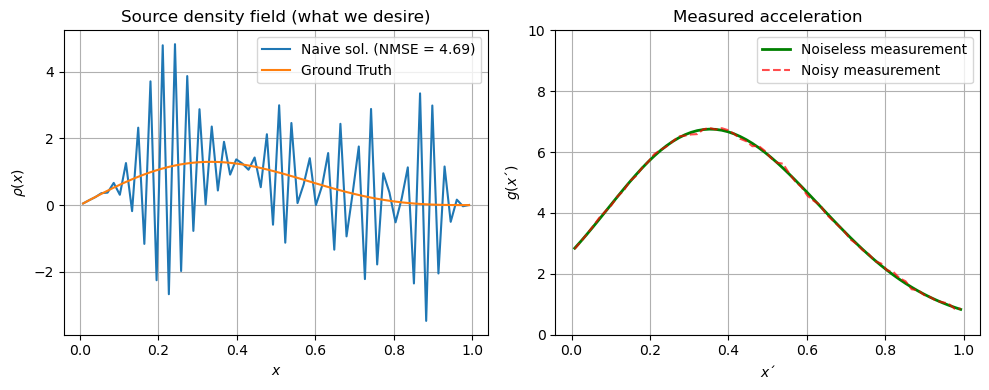

In [31]:
########### Naive Sol (SVD) ####################
[U,s,V] = lc.csvd(A)
beta = np.conj(U).T @ gxl; # Hermitian is just for matrices - but here A is real
xi = beta/s  
x_naive = V @ xi
nmse = lc.nmse(x_naive, rhox)
print('NMSE = {}'.format(nmse))
############ Figure ###########################
fig, axs = plt.subplots(1, 2, figsize = (10,4))
axs[0].plot(x, x_naive, label = r'Naive sol. (NMSE = {:.2f})'.format(nmse))
axs[0].plot(x, rhox, label = 'Ground Truth')
axs[0].legend()
axs[0].grid(True)
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$\rho(x)$')
axs[0].set_title(r'Source density field (what we desire)')
axs[1].plot(x, gxl, '-g', linewidth = 2, label = r'Noiseless measurement')
axs[1].plot(x, gxln, '--r', label = r'Noisy measurement', alpha = 0.7)
axs[1].set_ylim((0, 10))
axs[1].legend(loc = 'upper right')
axs[1].grid(True)
axs[1].set_xlabel(r'$x´$')
axs[1].set_ylabel(r'$g(x´)$')
axs[1].set_title(r'Measured acceleration')
plt.tight_layout()


# Otimização com restrição

Na primeira aula nós vimos uma forma de restringir a solução, dada por

\begin{equation}
\text{min}(\left\|\textbf{x}\right\|^{2}_{2}), \ \ \, \text{subjected to} \ \ \ \left\|\textbf{Ax -  b}\right\|^{2}_{2} \leq \left\|\textbf{n}\right\|^{2}_{2}
\end{equation}

Vamos investigar como isso funciona, assumimos que "conhecemos" $\textbf{n}$ com algum grau de confiança.

Vamos investigar como o problema da gravidade se comporta para várias escolhas de $k$ (um fator que multiplica $\left\|\textbf{n}\right\|^{2}_{2}$ na desigualdade anterior). 

In [62]:
# ordem
order = 64
# intervalo de medição
a = 0
b = 1
# distancia medida
d = 0.25
A, x = tp.gravity_model(n = order,a = a, b = b,d = d)
[U,s,V] = lc.csvd(A)

rhox = tp.density_sin(x, 0.5) + 0.5* tp.density_sin(x, 1.0)
#rhox = tp.density_pieciwise(n) 

gxl = A @ rhox

n = np.random.normal(loc = 0.0, scale = 0.001, size = len(gxl))
gxln = gxl + n

## Picard plot
#lc.plot_picard(U,s,gxln, noise_norm = np.linalg.norm(n))

In [63]:
factors = [20,10, 1.2, 1]#[10, 7, 5, 3, 2, 1, 0.5, 0.1, 0.05, 0.005]
rhox_st = []
nmse = []
for fac in factors:
    xh = lc.cvx_solver(A, gxln, fac*np.linalg.norm(n) , l_norm = 2)
    rhox_st.append(xh)
    nmse.append(lc.nmse(xh, rhox))

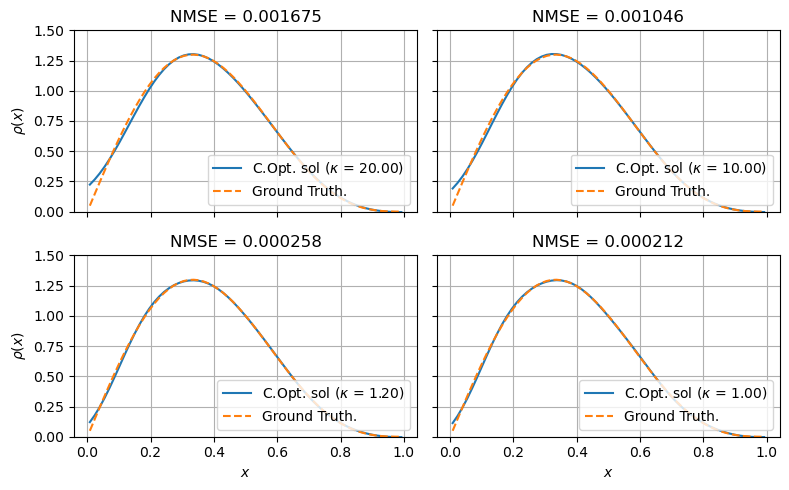

In [64]:
fig, axs = plt.subplots(2, 2, figsize = (8,5), sharex=True, sharey=True)
j = 0
for row in np.arange(2):
    for col in np.arange(2):
        axs[row,col].plot(x, rhox_st[j], label = r'C.Opt. sol ($\kappa$ = {0:.2f})'.format(factors[j]))
        axs[row,col].plot(x, rhox, '--', label = 'Ground Truth.')
        axs[row,col].set_title(r'NMSE = {0:.6f}'.format(nmse[j]))
        #axs[row,col].set_ylim((0.9*np.amin(rhox),1.1*np.amax(rhox)));
        axs[row,col].set_ylim((0,1.5)); 
        axs[row,col].grid()
        axs[row,col].legend(loc = 'lower right')
        j += 1
        axs[1,col].set_xlabel(r'$x$')
    axs[row,0].set_ylabel(r'$\rho(x)$')
plt.tight_layout()

# Será que é fácil medir o ruído?

- Há situações em que a gente não consegue desligar a fonte e medir o ruído (e.g. o problema da gravidade)
- No caso da medição sequencial, pode ser complicado porque a cada medição você precisa medir o ruído, o que aumenta muito o tempo de medição e complica o processamento.

# Truncated SVD

Vamos começar com o mais simples. 

É evidente que os erros extremamente grandes na solução ingênua provêm dos **componentes ruidosos da SVD**, associados aos menores valores singulares (Picard plot) e maiores frequências espaciais. 

A boa notícia é que nossa análise revela que uma parte dos valores singulares é confiável. 

Particularmente, os componentes para que $|\textbf{u}_{i}^{T}\textbf{b}| / \sigma_i \approx |\textbf{u}_{i}^{T}\textbf{b}_{exa}| / \sigma_i$ (claro, isso é válido se o valor exato da solução satisfizer o critério de Picard - o que é bastante razoável).

Estas considerações conduzem imediatamente a um método de "força bruta" para calcular para calcular soluções aproximadas regularizadas: basta **cortar** os componentes do SVD que são dominados pelo ruído. Assim, definimos a solução SVD truncada (**TSVD** - Truncated Singular Value Decomposition), $\hat{\textbf{x}}_k$, como a solução obtida mantendo os primeiros $k$ componentes da solução ingénua

\begin{equation}
\hat{\textbf{x}}_k = \sum\limits_{i=1}^{k}\varphi_i\frac{\textbf{u}_{i}^{H}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}
em que 

\begin{equation}
    \varphi_{i}^{[k]} = 
    \begin{cases}
      1 \ \ \ \ \ \ \ i \leq k  \\
      0 \ \ \ \ \ \ \ i > k
    \end{cases}\
\end{equation}

com $k$ escolhido de forma que os componentes ruidosos sejam eliminados. Essa escolha pode ser feita com base na **inspeção visual** do plot de Picard (portanto, não é muito automática).

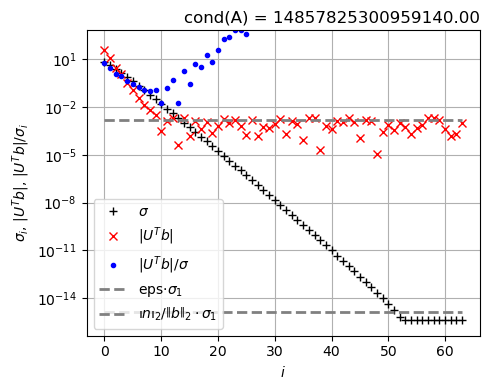

In [65]:
# ordem
order = 64
# intervalo de medição
a = 0
b = 1
# distancia medida
d = 0.25
A, x = tp.gravity_model(n = order,a = a, b = b,d = d)
[U,s,V] = lc.csvd(A)

rhox = tp.density_sin(x, 0.5) + 0.5* tp.density_sin(x, 1.0)
#rhox = tp.density_pieciwise(n) 

gxl = A @ rhox

n = np.random.normal(loc = 0.0, scale = 0.001, size = len(gxl))
gxln = gxl + n

## Picard plot
lc.plot_picard(U,s,gxln, noise_norm = np.linalg.norm(n))

In [68]:
ks = [2, 4, 6, 8, 10, 12, 14, 16 , 18]
rhox_k = []
nmse = []
sol_norm = []
for k in ks:
    xk = lc.tsvd(U, s, V, gxln, k)
    sol_norm.append(np.linalg.norm(xk))
    rhox_k.append(xk)
    nmse.append(lc.nmse(xk, rhox))    

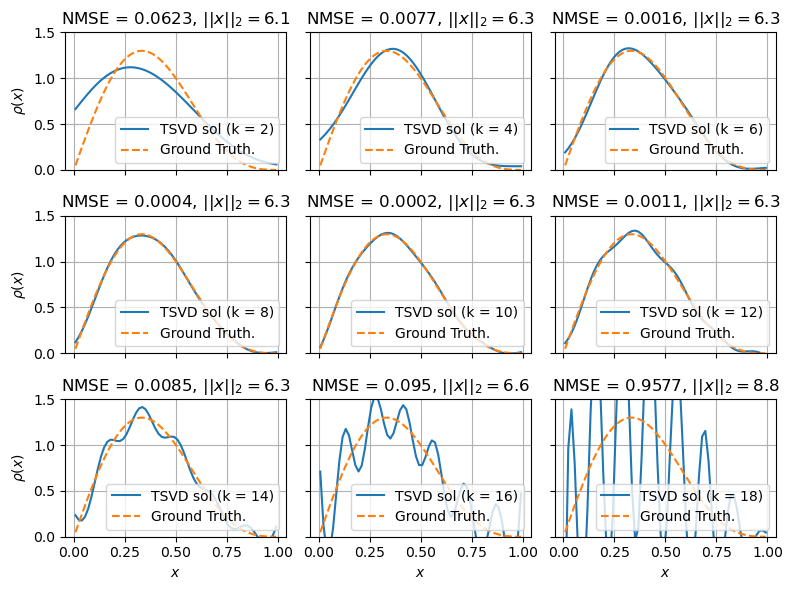

In [79]:
fig, axs = plt.subplots(3, 3, figsize = (8,6), sharex=True, sharey=True)
j = 0
for row in np.arange(3):
    for col in np.arange(3):
        axs[row,col].plot(x, rhox_k[j], label = r'TSVD sol (k = {0:.0f})'.format(ks[j]))
        axs[row,col].plot(x, rhox, '--', label = 'Ground Truth.')
        axs[row,col].set_title(r'NMSE = {}, $||x||_2 = {}$'.format(np.round(nmse[j],4), np.round(sol_norm[j],1)))
        #axs[row,col].set_ylim((0.9*np.amin(rhox),1.1*np.amax(rhox)));  
        axs[row,col].set_ylim((0,1.5));  
        axs[row,col].grid()
        axs[row,col].legend(loc = 'lower right')
        j += 1
        axs[2,col].set_xlabel(r'$x$')
    axs[row,0].set_ylabel(r'$\rho(x)$')
plt.tight_layout()

# O caminho de regularização no TSVD

- Quanto maior é $k$, menos regularizado é o problema;
- Quanto menos regularizado, maior é o resíduo da solução: $\left\|\textbf{Ax-b}\right\|^{2}_{2}$ 
- a comunidade de **machine learning** chama isso de **over-fitting** porque o modelo tenta se ajustar bem demais ao que é medido (com ruído), mas acaba se ajustando ao ruído presente e a solução fica cheia de oscilações;
- Quanto mais regularizado, menor tende a ser a norma da solução $\left\|\textbf{x}\right\|^{2}_{2}$;
- Existe um valor ótimo de $k$, para o qual o $\text{NMSE}$ é o menor - neste caso $k = 10 (12)$ (uma inspeção visual no plot de Picard pode ser muito útil);

# Selective SVD (SSVD)

A ideia básica na regularização TSVD é incluir todos os componentes SVD correspondentes aos maiores valores singulares. A lógica subjacente a estes e a muitos outros métodos de regularização é que o problema satisfaz a condição de Picard.

Mas será sempre necessário incluir todos estes componentes da SVD? A resposta é, evidentemente, negativa. Por exemplo, podemos facilmente imaginar um problema em que, digamos, cada segundo componente da SVD é zero ($\textbf{v}_{2}^{T} \textbf{x}_{exa} = \textbf{v}_{4}^{T} \textbf{x}_{exa} = \textbf{v}_{6}^{T} \textbf{x}_{exa} = \cdots = 0$). Não há necessidade de incluir estes componentes da SVD.

Uma variante do método TSVD é o selective SVD (**SSVD**). Este método é interessante por si só e é também importante em relação a alguns dos métodos iterativos de solução. No método SSVD incluímos apenas os componentes da SVD que contribuem significativamente para a solução regularizada. Especificamente, a solução SSVD é definida como

\begin{equation}
\hat{\textbf{x}}_{\tau} = \sum\limits_{|\textbf{u}_{i}^{H}\textbf{b}|>\tau}\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}

Somamos todos os componentes da SVD $\frac{\textbf{u}_{i}^{H}\textbf{b}}{\sigma_i}$ para os quais o valor absoluto, $|\textbf{u}_{i}^{H}\textbf{b}|$, do coeficiente do coeficiente SVD do lado direito é superior ao limiar $\tau$. Assim, os fatores de filtragem para o método o método SSVD são

\begin{equation}
    \varphi_{i}^{[\tau]} = 
    \begin{cases}
      1 \ \ \ \ \ \ \ |\textbf{u}_{i}^{T}\textbf{b}| > \tau  \\
      0 \ \ \ \ \ \ \ \text{caso contrário}
    \end{cases}\
\end{equation}

É natural escolher o limiar $\tau$ de modo a que os filtros SSVD removam os coeficientes os coeficientes $\textbf{u}_{i}^{T}\textbf{b}$ abaixo do nível de ruído. Assim, podemos escolher

\begin{equation}
\tau = \upsilon_s \eta
\end{equation}
em que $\eta$ representa o valor RMS (desvio padrão) do ruído e $\upsilon_s$ é um fator de segurança. Naturalmente, isso pressupõe que podemos medir o ruído de alguma forma. Vamos investigar um caso em que SSVD pode ser vantajoso com respeito ao TSVD.

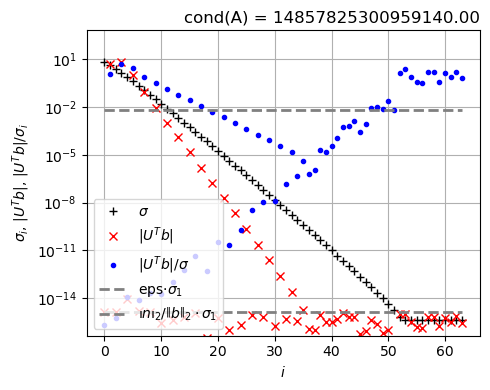

In [80]:
rhox = tp.density_sin(x, 2)
gxl = A @ rhox

n = np.random.normal(loc = 0.0, scale = 0.001, size = len(gxl))
gxln = gxl + n

## Picard plot
lc.plot_picard(U,s,gxl, noise_norm = np.linalg.norm(n))

In [81]:
safety_s = [4.6, 4, 1]
rhox_tau = []
nmse = []
for saf in safety_s:
    xtau = lc.ssvd(U, s, V, gxl, saf*np.finfo(float).eps)
    rhox_tau.append(xtau)
    nmse.append(lc.nmse(xtau, rhox))

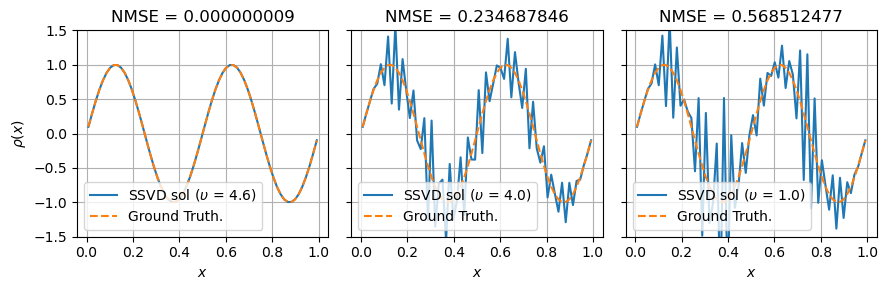

In [86]:
fig, axs = plt.subplots(1, 3, figsize = (9,3), sharex=True, sharey=True)
j = 0
for row in np.arange(3):
    axs[row].plot(x, rhox_tau[j], label = r'SSVD sol ($\upsilon$ = {0:.1f})'.format(safety_s[j]))
    axs[row].plot(x, rhox, '--', label = 'Ground Truth.')
    axs[row].set_title(r'NMSE = {0:.9f}'.format(nmse[j]))
    axs[row].set_ylim((-1.5,1.5));  
    axs[row].grid()
    axs[row].legend(loc = 'lower left')
    j += 1
    axs[row].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$\rho(x)$')
plt.tight_layout()

# Regularização de Tikhonov

A vantagem do método **TSVD** é o fato de ser intuitivo e de ser fácil calcular as soluções, $x_k$, para diferentes parâmetros de truncagem. A desvantagem é o fato de requerer explicitamente o cálculo da SVD ou, pelo menos, dos $k$ componentes. Esta tarefa computacional pode ser demasiado pesada para problemas de grande escala, embora às vezes seja difícil escapar dela.

Provavelmente, o método de regularização mais bem sucedido de todos os tempos é a regularização de Tikhonov. Este método foi inventado várias vezes, em várias encarnações (ver Apêndice C do livro); mas o nome de Tikhonov está corretamente associado ao método. De forma semelhante A formulação da TSVD em, o método de Tikhonov incorpora explicitamente o requisito de regularidade na formulação do problema. Especificamente, a solução de Tikhonov é definida como a solução do problema

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \text{min}(\left\|\textbf{Ax-b}\right\|^{2}_{2} + \lambda^2\left\|\textbf{x}\right\|^{2}_{2})
\end{equation}
em que $\lambda>0$ é o parâmetro de regularização, que controla os pesos dos dois ingredientes na minimização, a saber

- **Resíduo**: o primeiro termo, $\left\|\textbf{Ax-b}\right\|^{2}_{2}$,  mede a qualidade do ajuste, ou seja, o quão bem a solução, $\hat{\textbf{x}}_{\lambda}$, prevê os dados (ruidosos) $\textbf{b}$. Obviamente, se este termo for demasiado grande, então $\hat{\textbf{x}}_{\lambda}$ não pode ser considerado como uma boa solução porque não "resolve o problema". Por outro lado, intuitivamente, não devemos tornar o resíduo menor do que a dimensão média dos erros em $\textbf{b}$; à semelhança dos problemas de ajuste de dados, não queremos ajustar nosso modelo ao ruído presente nos dados (**over-fiiting**).

- **Norma da solução**: o segundo termo, $\left\|\textbf{x}\right\|^{2}_{2}$, mede a regularidade da solução. A incorporação deste termo baseia-se no nosso conhecimento de que a solução ingênua é dominada por componentes de alta-frequência, com grandes amplitudes (amplificados). A esperança é, portanto, que se controlarmos a norma de $\textbf{x}$, então podemos suprimir (a maioria) os componentes de ruído.

## O caminho de regularização na solução de Tikhonov

O equilíbrio entre os dois termos é controlado pelo fator $\lambda^2$ (ou $\lambda$ em alguns livros). Quanto maior o $\lambda$, mais peso é dado à minimização da norma da solução $\left\|\textbf{x}\right\|^{2}_{2}$ e, portanto, à regularidade da solução (notamos que $\left\|\textbf{x}\right\|^{2}_{2}\rightarrow 0$ à medida que $\lambda \rightarrow \infty$ - caminho de regularização). Por outro lado, quanto menor for $\lambda$, mais peso é dado ao ajuste dos dados ruidosos, resultando em soluções menos regulares (obtemos o problema original e a solução "ingênua" por mínimos quadrados quando $\lambda = 0$).

## Solução analítica

Pode-se demonstrar que a solução de Tikhonov tem solução analítica do seguinte problema de mínimos quadrados

\begin{gather}
\hat{\textbf{x}}_{\lambda} = \text{min}\left(\left\|
  \begin{bmatrix}
   \textbf{A} \\ \lambda \textbf{I} 
   \end{bmatrix}
   - 
   \begin{bmatrix}
   \textbf{b} \\ \textbf{0} 
   \end{bmatrix}
   \right\|_{2}\right)
\end{gather}
com soluão dada por:

\begin{equation}
\hat{\textbf{x}}_{\lambda} = (\textbf{A}^T\textbf{A}+\lambda^2\textbf{I})^{-1}\textbf{A}^T \textbf{b}
\end{equation}

**NOTE**: o SVD mantêm as dimensões originais de $\textbf{A}$, enquanto $\textbf{A}^T\textbf{A}$ ($(L \times M) \times (M \times L$)) pode ter uma dimensão bem maior e, portanto, ter um número de condição ainda pior que o problema original. Por isso, as vezes não conseguimos escapar do SVD ou do problema de mínimos quadrados anterior.

Podemos usar a expansão de $\textbf{A}= \textbf{U} \Sigma \textbf{V}^H$ e sua pseudo-inversa e lembrar que $\textbf{V}^H\textbf{V} = \textbf{I}$. Dessa forma, obtemos

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \textbf{V}(\Sigma^2+\lambda^2\textbf{I})^{-1} \ \Sigma \textbf{U}^H \textbf{b}
\end{equation}

que comparado à

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \sum\limits_{i=1}^{L}\varphi_{i}^{[\lambda]}\frac{\textbf{u}_{i}^{H}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}
nos permite inferir que os **fatores de filtragem** são

\begin{equation}
    \varphi_{i}^{[\lambda]} = \frac{\sigma_{i}^{2}}{\sigma_{i}^{2}+\lambda^2} \approx
    \begin{cases}
      1 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \sigma_i \gg \lambda \\
      \sigma_{i}^{2}/\lambda^2 \ \ \ \ \ \ \ \sigma_i \ll \lambda
    \end{cases}\
\end{equation}

Observemos o que ocorre quando usamos diferentes valores em $\lambda$

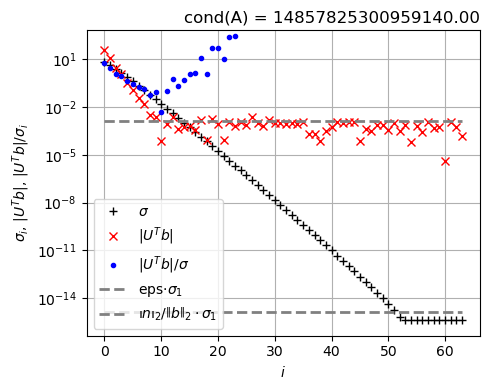

In [91]:
# ordem
order = 64
# intervalo de medição
a = 0
b = 1
# distancia medida
d = 0.25
A, x = tp.gravity_model(n = order,a = a, b = b,d = d)
[U,s,V] = lc.csvd(A)

rhox = tp.density_sin(x, 0.5) + 0.5* tp.density_sin(x, 1.0)
#rhox = tp.density_pieciwise(order) 

gxl = A @ rhox

#np.random.seed(seed = 10)
n = np.random.normal(loc = 0.0, scale = 0.001, size = len(gxl))
gxln = gxl + n

## Picard plot
lc.plot_picard(U,s,gxln, noise_norm = np.linalg.norm(n))

In [92]:
#lambdas = [10, 2.6827, 0.71969, 0.19307, 0.151795, 0.01786, 0.0037276, 0.001 , 0.0005]
lambdas = [10, 2.5, 0.7, 0.2, 0.05, 0.015, 0.01, 0.0015 , 0.0005]
rhox_lam = []
nmse = []
sol_norm = []
for lam in lambdas:
    xlam = lc.tikhonov(U, s, V, gxln, lam)
    sol_norm.append(np.linalg.norm(xlam))
    rhox_lam.append(xlam)
    nmse.append(lc.nmse(xlam, rhox))  

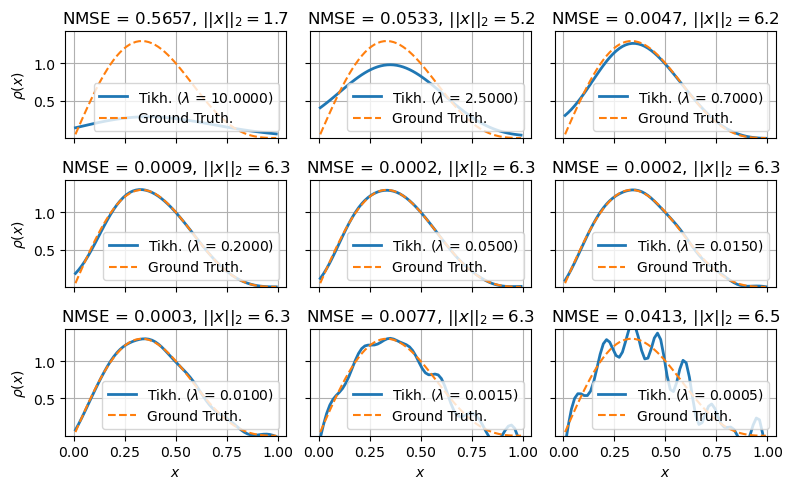

In [95]:
fig, axs = plt.subplots(3, 3, figsize = (8,5), sharex=True, sharey=True)
j = 0
for row in np.arange(3):
    for col in np.arange(3):
        axs[row,col].plot(x, rhox_lam[j], linewidth = 2, label = r'Tikh. ($\lambda$ = {0:.4f})'.format(lambdas[j]))
        axs[row,col].plot(x, rhox, '--', label = 'Ground Truth.')
        #axs[row,col].set_title(r'NMSE = {0:.6f}'.format(nmse[j]))
        axs[row,col].set_title(r'NMSE = {}, $||x||_2 = {}$'.format(np.round(nmse[j],4), np.round(sol_norm[j],1)))
        axs[row,col].set_ylim((0.9*np.amin(rhox),1.1*np.amax(rhox)));  
        axs[row,col].grid()
        axs[row,col].legend(loc = 'lower right')
        j += 1
        axs[2,col].set_xlabel(r'$x$')
    axs[row,0].set_ylabel(r'$\rho(x)$')
plt.tight_layout()

### O efeito da filtragem no plot de Picard

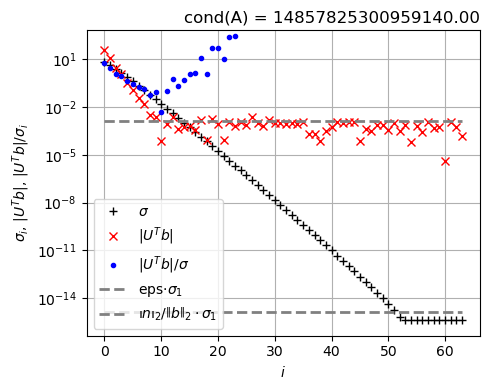

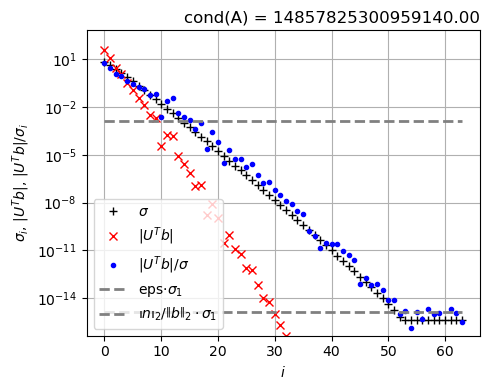

In [96]:
phi_lam = s**2/(s**2+lambdas[5]**2)
lc.plot_picard(U, s, gxln, noise_norm = np.linalg.norm(n))
lc.plot_picard(U*phi_lam, s, gxln, noise_norm = np.linalg.norm(n))

## Retomando:

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \sum\limits_{i=1}^{L}\varphi_{i}^{[\lambda]}\frac{\textbf{u}_{i}^{H}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}
com os **fatores de filtragem** sendo

\begin{equation}
    \varphi_{i}^{[\lambda]} = \frac{\sigma_{i}^{2}}{\sigma_{i}^{2}+\lambda^2} \approx
    \begin{cases}
      1 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \sigma_i \gg \lambda \\
      \sigma_{i}^{2}/\lambda^2 \ \ \ \ \ \ \ \sigma_i \ll \lambda
    \end{cases}\
\end{equation}

- O comportamento destes fatores de filtragem é ilustrado a seguir. Vemos que, para valores singulares $\sigma_i \gg \lambda$, os fatores de filtragem $\varphi_{i}^{[\lambda]} \approx 1.0$ e os componentes da SVD correspondentes contribuem para $\hat{\textbf{x}}_{\lambda}$ com força quase total. 

- Por outro lado, para $\sigma_i \ll \lambda$, os fatores de filtragem são pequenos e, portanto, estas componentes da SVD são amortecidas ou filtradas. Notamos que, neste último caso, os fatores de filtragem $\varphi_{i}^{[\lambda]}$ são proporcionais a $\sigma_{i}^{2}$, e portanto, decaem suficientemente rápido para "matar" os fatores crescentes $\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \approx \frac{\textbf{u}_{i}^{T}\textbf{n}}{\sigma_i}$.

- No entanto, a transição entre os componentes entre componentes SVD retidos e filtrados é mais suave que no TSVD.

Observe o valor de $\varphi_{i}^{[\lambda]}$ vs. $\sigma_i$

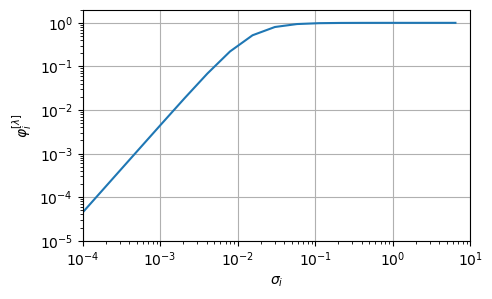

In [99]:
idx = 5
phi_lam = s**2/(s**2+lambdas[idx]**2)

plt.figure(figsize = (5,3))
plt.loglog(s, phi_lam)
plt.xlabel(r'$\sigma_i$')
plt.ylabel(r'$\varphi_{i}^{[\lambda]}$')
plt.xlim((1e-4, 10))
plt.ylim((1e-5, 2))
plt.grid()

# A curva L (L-curve)

Analisemos mais de perto a **norma da solução** ($\left\|\textbf{x}\right\|_{2}$) e a **norma residual** ($\left\|\textbf{Ax-b}\right\|_{2}$). Estas normas desempenham um papel central no tratamento prático de problemas discretos mal postos, porque podem sempre ser calculadas independentemente do método de regularização utilizado; não requerem o cálculo da SVD (necessariamente) ou de qualquer outra decomposição da matriz, e fornecem uma boa intuição sobre a escolha de $\lambda$.

Vamos calcular $\left\|\textbf{x}\right\|_{2}$ vs. $\left\|\textbf{Ax-b}\right\|_{2}$ para vários valores de $\lambda$ e ver o que acontece em uma escala log-log.

In [100]:
lambdas = np.logspace(-5, 1, num=100)
sol_norms = np.zeros(len(lambdas))
residuals = np.zeros(len(lambdas))
for jl, lam in enumerate(lambdas):
    xlam = lc.tikhonov(U, s, V, gxln, lam)
    sol_norms[jl] = np.linalg.norm(xlam)
    residuals[jl] = np.linalg.norm(A @ xlam - gxln)

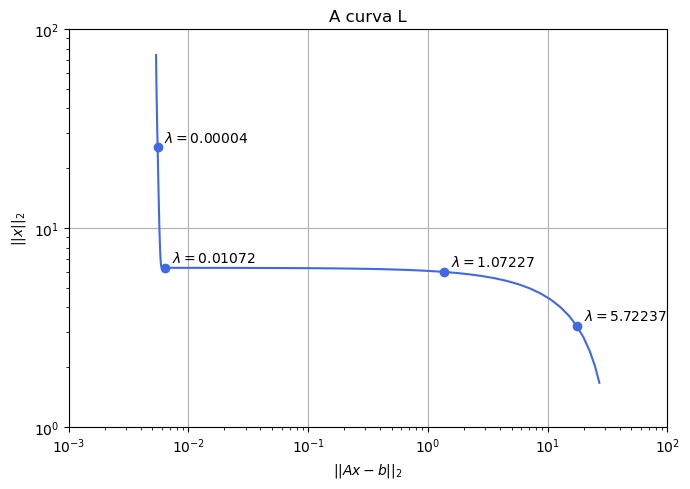

In [104]:
plt.figure(figsize = (7,5))
plt.loglog(residuals, sol_norms, color = 'Royalblue')
plt.loglog(residuals[[10, 50, 83, 95]], sol_norms[[10, 50, 83, 95]],  'o', color = 'Royalblue')
for num in [10, 50,83, 95]:
    label = r"$\lambda = ${:.5f}".format(lambdas[num])
    plt.annotate(label, (residuals[num], sol_norms[num]), # these are the coordinates to position the label
         textcoords="offset points", # how to position the text
         xytext=(35, 4), # distance from text to points (x,y)
         ha='center') 
plt.grid()
plt.ylim((1, 100))
plt.xlim((0.001, 100))
plt.xlabel(r'$||A x - b||_2$')
plt.ylabel(r'$||x||_2$')
plt.title("A curva L")
plt.tight_layout();

- A curva tem um comportamento típico, que aparece em muitas situações (um "L").

- Quando $\lambda$ é grande demais, então a solução $\hat{\textbf{x}}_{\lambda}$ é sobre-suavizada , já que a norma da solução é muito penalizada na minimização. Este é um caso de **under-fitting** do modelo aos dados medidos.

- Quando $\lambda$ é pequeno demais, então a solução $\hat{\textbf{x}}_{\lambda}$ é sub-suavizada, já que a norma da solução é pouco penalizada na minimização. Este é um caso de **over-fitting** do modelo aos dados medidos - o modelo se ajusta ao ruído.

## A questão que fica é: será que conseguimos achar o valor ótimo de $\lambda$?

- A boa notícia é que **sim** e que há mais de um método. Veremos na próxima aula.

Optimal regularization parameter by L-curve: 0.0011157812390988472


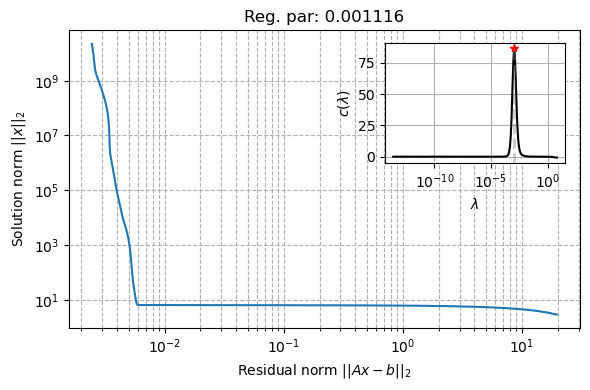

In [124]:
lam_opt = lc.l_curve(U, s, gxln, plotit = True)
print("Optimal regularization parameter by L-curve: {}".format(lam_opt[0]))

# Reconstrução

Em algumas situações é desejado que nós reconstruamos uma quantidade desejada em posições que não medimos. Por exemplo, no caso do problema investigado aqui, podemos medir a aceleração da gravidade $g(x')$ a uma distância $d = 0.25$ m da fonte. Note que:

- $d = 0$ m representa uma origem hipotética do campo de densidades. É o nosso termo fonte e, usualmente, não conseguimos reconstruir nada que para $d<0$ (nossa área de reconstrução não deve **conter fontes**);
- Mas podemos reconstruir $g(x')$ para $d = 0.10$ m (mais perto que o plano de medição) ou  $d = 0.5$ m (mais longe que o plano de medição).

A reconstrução é um problema direto. Note que já computamos $\textbf{x}$ pelo problema inverso regularizado. Precismos então computar

\begin{equation}
\textbf{b}_{\text{r}} = \textbf{A}_{\text{r}} \hat{\textbf{x}}
\end{equation}
em que $\textbf{A}_{\text{r}}$ é a matriz de reconstrução avaliada nas posições de reconstrução desejadas.

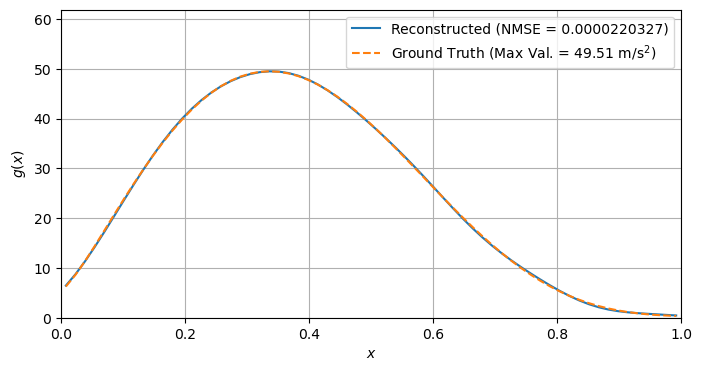

In [121]:
x_lam = rhox_lam[5]

# distancia de reconstrução desejada
dr = 0.5


# Matriz de reconstrução
Ar, xr = tp.gravity_model(n = order,a = a, b = b,d = dr)

# Ground Truth
gxt = Ar @ rhox
# reconstruido
gxr = Ar @ x_lam

nmse = lc.nmse(gxt, gxr)

############ Figure ###########################
plt.figure(figsize = (8,4))
plt.plot(x, gxr, label = r'Reconstructed (NMSE = {:.10f})'.format(nmse))
plt.plot(x, gxt, '--', label = 'Ground Truth (Max Val. = {:.2f} m/s$^2$)'.format(np.amax(gxt)))
plt.legend()
plt.grid()
plt.ylim((0,1.25*np.amax(gxr)))
plt.xlim((0,1))
plt.xlabel(r'$x$')
plt.ylabel(r'$g(x)$');